In [4]:
import requests
import shutil
import os
import pathlib
import pandas as pd
import numpy as np

import copy
import multiprocessing as mp
from IPython.display import Image, display
from pathlib import Path

In [5]:
!pip install -qq fastai

In [6]:
hdf = pd.read_csv('data/gz2_hart16.csv')
hdf.head(10)

,dr7objid,ra,dec,rastring,decstring,sample,gz2_class,total_classifications,total_votes,t01_smooth_or_features_a01_smooth_count,...,t11_arms_number_a36_more_than_4_fraction,t11_arms_number_a36_more_than_4_weighted_fraction,t11_arms_number_a36_more_than_4_debiased,t11_arms_number_a36_more_than_4_flag,t11_arms_number_a37_cant_tell_count,t11_arms_number_a37_cant_tell_weight,t11_arms_number_a37_cant_tell_fraction,t11_arms_number_a37_cant_tell_weighted_fraction,t11_arms_number_a37_cant_tell_debiased,t11_arms_number_a37_cant_tell_flag
0,587732591714893851,179.042984,60.522518,11:56:10.32,+60:31:21.1,original,Sc+t,45,342,0,...,0.450,0.450,0.482646,0,16,16.0,0.400,0.400,0.394506,0
1,588009368545984617,135.084396,52.494240,09:00:20.26,+52:29:39.3,original,Sb+t,42,332,1,...,0.512,0.503,0.504833,0,13,13.0,0.317,0.323,0.322743,0
2,587732484359913515,183.371979,50.741508,12:13:29.27,+50:44:29.4,original,Ei,36,125,28,...,0.000,0.000,0.000000,0,0,0.0,0.000,0.000,0.000000,0
3,587741723357282317,186.251953,28.558598,12:25:00.47,+28:33:31.0,original,Sc+t,28,218,1,...,0.240,0.240,0.241322,0,6,6.0,0.240,0.240,0.239765,0
4,587738410866966577,161.086395,14.084465,10:44:20.73,+14:05:04.1,original,Er,43,151,33,...,0.000,0.000,0.000000,0,0,0.0,0.000,0.000,0.000000,0
5,587729751132209314,246.921387,40.926968,16:27:41.13,+40:55:37.1,extra,Ei,48,154,41,...,0.000,0.000,0.000000,0,0,0.0,0.000,0.000,0.000000,0
6,587733608555216981,249.474640,36.073040,16:37:53.91,+36:04:22.9,original,Ei,39,142,25,...,0.000,0.000,0.000000,0,0,0.0,0.000,0.000,0.000000,0
7,587735742617616406,243.146759,29.365067,16:12:35.22,+29:21:54.2,original,Sb+t,35,282,0,...,0.457,0.442,0.480484,0,8,8.0,0.229,0.235,0.230543,0
8,587738574068908121,195.278030,39.841473,13:01:06.73,+39:50:29.3,original,Ei,50,158,42,...,0.000,0.000,0.000000,0,0,0.0,0.000,0.000,0.000000,0
9,587731870708596837,183.062057,56.177532,12:12:14.89,+56:10:39.1,original,Sb?t,43,275,8,...,0.048,0.048,0.049229,0,9,9.0,0.429,0.429,0.426677,0


In [7]:
hart_morph_class = hdf.gz2_class.unique()
print(f'Number of Hart16 morphological galaxy classes: {len(hart_morph_class)}')


Number of Hart16 morphological galaxy classes: 818


In [8]:
def sdss_get_params(ra, dec, scale=0.2, width=256, height=256, opt=''):
    return {
        'TaskName': 'Skyserver.Chart.Navi',
        'ra'      : ra,
        'dec'     : dec,
        'scale'   : scale,
        'width'   : width,
        'height'  : height,
        'opt'     : opt
    }


def sdss_download_image(dest_path, params, filename, force=False):
    base_url='http://skyserver.sdss.org/dr15/SkyServerWS/ImgCutout/getjpeg'
    image_file = f'{dest_path}/{filename}.jpg'
    image_path = Path(image_file)
    if image_path.is_file() and force == False:
        return { 'success': True, 'file': image_file, 'code': 303 }
    resp = requests.get(base_url, params)
    if resp.status_code == 200:
        with open(image_file, 'wb') as f:
            f.write(resp.content)
        return { 'success': True, 'file': image_file, 'code': resp.status_code }
    else:
        return { 'success': False, 'file': image_file, 'code': resp.status_code }
    

from fastprogress.fastprogress import master_bar, progress_bar
from time import sleep
from fastai.vision.all import *


def sdss_download_dataset(hdf, morph_class, base_path, per_class_limit=25):
    image_count = 0
    mb = master_bar(range(len(morph_class)))
    for i in mb:
        mc=morph_class[i]
        mc_path = f'{base_path}/{mc}'
        os.makedirs(mc_path, exist_ok=True)
        mb.main_bar.comment = f'{mc} Class'
        mc_count = ([name for name in os.listdir(mc_path) if os.path.isfile(os.path.join(mc_path, name))])
        if mc_count >= per_class_limit:
            continue    
        rows = hdf[hdf['gz2_class'] == mc].sample(per_class_limit, replace=True)
        pb = progress_bar(range(per_class_limit), parent=mb)
        for index in pb:
            sleep(1)
            row = rows.iloc[index]
            result = sdss_download_image(mc_path, sdss_get_params(
                        row['ra'], 
                        row['dec']),
                        row['dr7objid'])
            if result['success']:
                mb.child.comment = f'{index} : {row["dr7objid"]}'
                image_count += 1
            else:
                print(f"Download failed    : {result['file']} [{result['code']}]!")
    failed = verify_images(get_image_files(base_path))
    failed.map(Path.unlink)
    return image_count - len(failed)

    

In [9]:
base_path = 'data/sdss_train'

sdss_download_dataset(hdf, hart_morph_class, base_path)

test_path = 'data/sdss_test'
sdss_download_dataset(hdf, hart_morph_class, test_path, per_class_limit=3)

Download failed    : data/sdss_train/Sc1m/587735490824568994.jpg [404]!
Download failed    : data/sdss_train/SBb?t(i)/587735489214152829.jpg [404]!
Download failed    : data/sdss_train/SBc?l(o)/588017721179308094.jpg [500]!
Download failed    : data/sdss_train/SBc?l(o)/587738197184938327.jpg [500]!
Download failed    : data/sdss_train/SBc?l(o)/588017721179308094.jpg [500]!
Download failed    : data/sdss_train/SBc?l(o)/587738197184938327.jpg [500]!
Download failed    : data/sdss_train/SBc?l(o)/588017721179308094.jpg [500]!
Download failed    : data/sdss_train/SBc?l(d)/588017720103141437.jpg [500]!
Download failed    : data/sdss_train/SBc?l(d)/588017704553808023.jpg [500]!
Download failed    : data/sdss_train/SBc?l(d)/588017704553808023.jpg [500]!
Download failed    : data/sdss_train/SBc?l(d)/588017704553808023.jpg [500]!
Download failed    : data/sdss_train/SBc?l(d)/588017720103141437.jpg [500]!
Download failed    : data/sdss_train/SBc?l(d)/587726031691382889.jpg [500]!
Download failed 

2454

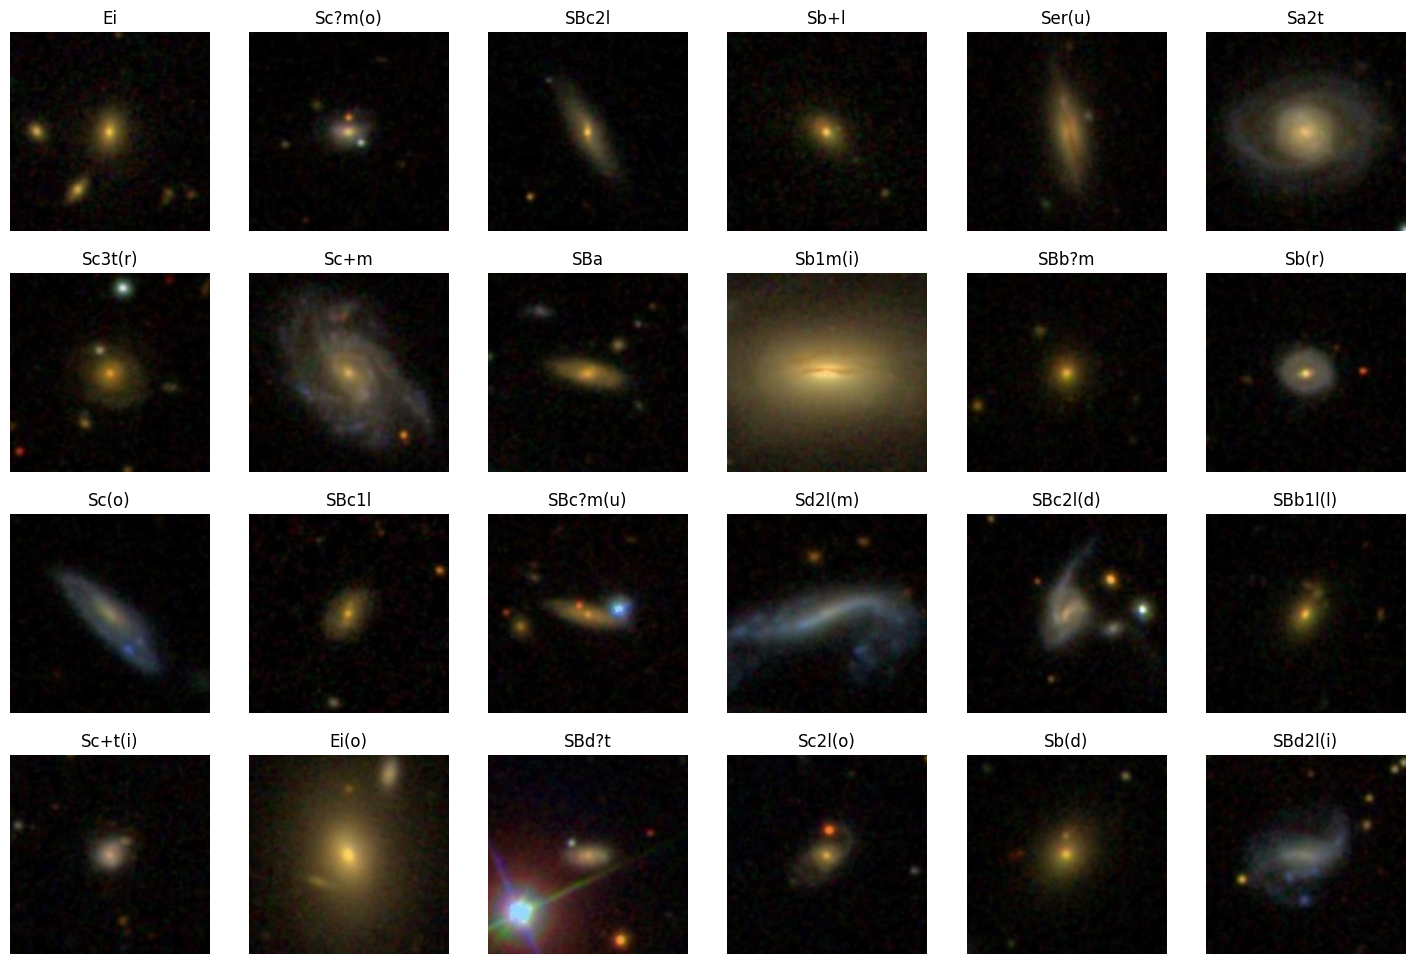

In [10]:
dls = DataBlock(
    blocks=(ImageBlock, CategoryBlock), 
    get_items=get_image_files, 
    splitter=RandomSplitter(valid_pct=0.2, seed=42),
    get_y=parent_label,
    item_tfms=[Resize(192, method='squish')]
).dataloaders(base_path, bs=64)

dls.show_batch(max_n=24)

In [11]:
learn = vision_learner(dls, resnet18, metrics=error_rate)


/Users/ajithj/Library/Python/3.8/lib/python/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/Users/ajithj/Library/Python/3.8/lib/python/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


In [12]:
learn.fine_tune(3)

epoch,train_loss,valid_loss,error_rate,time


KeyError: "Label 'SBa2l(r)' was not included in the training dataset"

In [ ]:
for mc in hart_morph_class:
    sample = hdf[hdf['gz2_class'] == mc].sample()
    result = sdss_download_image('data/sdss_test', sdss_get_params(
                sample['ra'], 
                sample['dec']),
                sample['dr7objid'])
    if result['success']:
        predict_class, _, probs = learn.predict(PILImage.create(result['file']))
        print("f{sample['dr7objid']} object located at RA {sample['ra']}, Dec {sample['dec']} : \
              Predicted Class={predict_class}, Confidence: {probs[0]:.2f}, GZ2 Class: {sample['gz2_class']}")
        
            


In [ ]:
def test_prediction(hdf, files):
  positive = 0
  negative = 0
  for f in files:
    object_id = os.path.basename(f)
    target_class = hdf[hdf['dr7objid'] == object_id]['gz2_class'].values.tolist()
    predict_class, _, probs = learn.predict(PILImage.create(f))
    print(f"Predicted Class={predict_class}, Confidence: {probs[0]:.2f}, Target Class: {target_class}")
    if predict_class in target_class:
      positive += 1
    else:
      negative += 1
  return (positive, negative)

success, failure = test_prediction(hdf, test_path)
print(f' success = {success}, failure = {failure}, TP Accuracy: {success/(success + failure):.4f}')


In [ ]:
# resnet_models = [resnet18, resnet34, resnet50, resnet101, resnet152 ]
# resnet_learners = {}
# for model in resnet_models:
#     print(f'Using model: {str(model)}')
#     resnet_learners[str(model)] = vision_learner(dls, model, metrics=error_rate)
    
# for i, (k, v) in enumerate(resnet_learners.items()):
#     print(f'Learn fine-tune model #{i}, {k}')
#     c.fine_tune(5, base_lr=0.01)

    
    

Contact:    Kyle Willett (willett@physics.umn.edu), Chris Lintott (cjl@astro.ox.ac.uk), or Jordan Raddick (raddick@jhu.edu) with any questions.
Reference:  The project and data release are described in Willett et al. (2013, submitted). Please cite this paper if making use of any data in this table in publications.

Description: Morphological classifications of main-sample spectroscopic galaxies from Galaxy Zoo 2

This table includes galaxies with spectra in SDSS Data Release 7. Several columns give data that can be used to cross-match rows with other SDSS tables, including objIDs and positions of the galaxies. Morphological classifications include six parameters for each category: unweighted and weighted versions of both the total number of votes and the vote fraction for that response, the vote fraction after being debiased, and flags for systems identified as being in clean samples.

Note that this table and dr10_gz2_stripe82_normal contain some of the same galaxies (with r < 17.0). 



Contact:    Kyle Willett (willett@physics.umn.edu), Chris Lintott (cjl@astro.ox.ac.uk), or Jordan Raddick (raddick@jhu.edu) with any questions.
Reference:  The project and data release are described in Willett et al. (2013, submitted). Please cite this paper if making use of any data in this table in publications.

Description: Morphological classifications of main-sample spectroscopic galaxies from Galaxy Zoo 2

This table includes galaxies with spectra in SDSS Data Release 7. Several columns give data that can be used to cross-match rows with other SDSS tables, including objIDs and positions of the galaxies. Morphological classifications include six parameters for each category: unweighted and weighted versions of both the total number of votes and the vote fraction for that response, the vote fraction after being debiased, and flags for systems identified as being in clean samples.

Note that this table and dr10_gz2_stripe82_normal contain some of the same galaxies (with r < 17.0). 



Contact:    Kyle Willett (willett@physics.umn.edu), Chris Lintott (cjl@astro.ox.ac.uk), or Jordan Raddick (raddick@jhu.edu) with any questions.
Reference:  The project and data release are described in Willett et al. (2013, submitted). Please cite this paper if making use of any data in this table in publications.

Description: Morphological classifications of main-sample spectroscopic galaxies from Galaxy Zoo 2

This table includes galaxies with spectra in SDSS Data Release 7. Several columns give data that can be used to cross-match rows with other SDSS tables, including objIDs and positions of the galaxies. Morphological classifications include six parameters for each category: unweighted and weighted versions of both the total number of votes and the vote fraction for that response, the vote fraction after being debiased, and flags for systems identified as being in clean samples.

Note that this table and dr10_gz2_stripe82_normal contain some of the same galaxies (with r < 17.0). 



In [ ]:
name                                                                type        length      unit    ucd     description
----------------------------------------------------------------------------------------------------------------------------------
specobjid                                                           bigint      8                           match to the DR8 spectrum object
dr8objid                                                            bigint      8                           match to the DR8 objID
dr7objid                                                            bigint      8                           match to the DR7 objID
ra                                                                  real        4                           right ascension [J2000.0], decimal degrees
dec                                                                 real        4                           declination [J2000.0], decimal degrees
rastring                                                            varchar     11                          right ascension [J2000.0], sexagesimal
decstring                                                           varchar     11                          declination [J2000.0], sexagesimal
sample                                                              varchar     20                          sub-sample identification
gz2class                                                            varchar     20                          shorthand string for the most common consensus morphology
total_classifications                                               int			4                           total number of classifications for this galaxy
total_votes                                                         int			4                           total number of votes for each response, summed over all classifications
t01_smooth_or_features_a01_smooth_count                             int			4                           number of votes for the "smooth" response to Task 01
t01_smooth_or_features_a01_smooth_weight                            float		8                           consistency-weighted number of votes for the "smooth" response to Task 01
t01_smooth_or_features_a01_smooth_fraction                          float		8                           fraction of votes for "smooth" out of all responses to Task 01
t01_smooth_or_features_a01_smooth_weighted_fraction                 float		8                           consistency-weighted fraction of votes for "smooth" out of all responses to Task 01
t01_smooth_or_features_a01_smooth_debiased                          float		8                           debiased fraction of votes for "smooth" out of all responses to Task 01
t01_smooth_or_features_a01_smooth_flag                              int			4                           flag for "smooth" - 1 if galaxy is in clean sample, 0 otherwise
t01_smooth_or_features_a02_features_or_disk_count                   int			4                           number of votes for the "features or disk" response to Task 01
t01_smooth_or_features_a02_features_or_disk_weight                  float		8                           consistency-weighted number of votes for the "features or disk" response to Task 01
t01_smooth_or_features_a02_features_or_disk_fraction                float		8                           fraction of votes for "features or disk" out of all responses to Task 01
t01_smooth_or_features_a02_features_or_disk_weighted_fraction       float		8                           consistency-weighted fraction of votes for "features or disk" out of all responses to Task 01
t01_smooth_or_features_a02_features_or_disk_debiased                float		8                           debiased fraction of votes for "features or disk" out of all responses to Task 01
t01_smooth_or_features_a02_features_or_disk_flag                    int			4                           flag for "features or disk"  - 1 if galaxy is in clean sample, 0 otherwise
t01_smooth_or_features_a03_star_or_artifact_count                   int			4                           number of votes for the "star or artifact" response to Task 01
t01_smooth_or_features_a03_star_or_artifact_weight                  float		8                           consistency-weighted number of votes for the "star or artifact" response to Task 01
t01_smooth_or_features_a03_star_or_artifact_fraction                float		8                           fraction of votes for "star or artifact" out of all responses to Task 01
t01_smooth_or_features_a03_star_or_artifact_weighted_fraction       float		8                           consistency-weighted fraction of votes for "star or artifact" out of all responses to Task 01
t01_smooth_or_features_a03_star_or_artifact_debiased                float		8                           debiased fraction of votes for "star or artifact" out of all responses to Task 01
t01_smooth_or_features_a03_star_or_artifact_flag                    int			4                           flag for "star or artifact"  - 1 if galaxy is in clean sample, 0 otherwise
t02_edgeon_a04_yes_count                                            int			4                           number of votes for the "edge-on" response to Task 02
t02_edgeon_a04_yes_weight                                           float		8                           consistency-weighted number of votes for the "edge-on" response to Task 02
t02_edgeon_a04_yes_fraction                                         float		8                           fraction of votes for "edge-on" out of all responses to Task 02
t02_edgeon_a04_yes_weighted_fraction                                float		8                           consistency-weighted fraction of votes for "edge-on" out of all responses to Task 02
t02_edgeon_a04_yes_debiased                                         float		8                           debiased fraction of votes for "edge-on" out of all responses to Task 02
t02_edgeon_a04_yes_flag                                             int			4                           flag for "edge-on"  - 1 if galaxy is in clean sample, 0 otherwise
t02_edgeon_a05_no_count                                             int			4                           number of votes for the "not edge-on" response to Task 02
t02_edgeon_a05_no_weight                                            float		8                           consistency-weighted number of votes for the "not edge-on" response to Task 02
t02_edgeon_a05_no_fraction                                          float		8                           fraction of votes for "not edge-on" out of all responses to Task 02
t02_edgeon_a05_no_weighted_fraction                                 float		8                           consistency-weighted fraction of votes for "not edge-on" out of all responses to Task 02
t02_edgeon_a05_no_debiased                                          float		8                           debiased fraction of votes for "not edge-on" out of all responses to Task 02
t02_edgeon_a05_no_flag                                              int			4                           flag for "not edge-on"  - 1 if galaxy is in clean sample, 0 otherwise
t03_bar_a06_bar_count                                               int			4                           number of votes for the "bar" response to Task 03
t03_bar_a06_bar_weight                                              float		8                           consistency-weighted number of votes for the "bar" response to Task 03
t03_bar_a06_bar_fraction                                            float		8                           fraction of votes for "bar" out of all responses to Task 03
t03_bar_a06_bar_weighted_fraction                                   float		8                           consistency-weighted fraction of votes for "bar" out of all responses to Task 03
t03_bar_a06_bar_debiased                                            float		8                           debiased fraction of votes for "bar" out of all responses to Task 03
t03_bar_a06_bar_flag                                                int			4                           flag for "bar"  - 1 if galaxy is in clean sample, 0 otherwise
t03_bar_a07_no_bar_count                                            int			4                           number of votes for the "no bar" response to Task 03
t03_bar_a07_no_bar_weight                                           float		8                           consistency-weighted number of votes for the "no bar" response to Task 03
t03_bar_a07_no_bar_fraction                                         float		8                           fraction of votes for "no bar" out of all responses to Task 03
t03_bar_a07_no_bar_weighted_fraction                                float		8                           consistency-weighted fraction of votes for "no bar" out of all responses to Task 03
t03_bar_a07_no_bar_debiased                                         float		8                           debiased fraction of votes for "no bar" out of all responses to Task 03
t03_bar_a07_no_bar_flag                                             int			4                           flag for "no bar"  - 1 if galaxy is in clean sample, 0 otherwise
t04_spiral_a08_spiral_count                                         int			4                           number of votes for the "spiral structure" response to Task 04
t04_spiral_a08_spiral_weight                                        float		8                           consistency-weighted number of votes for the "spiral structure" response to Task 04
t04_spiral_a08_spiral_fraction                                      float		8                           fraction of votes for "spiral structure" out of all responses to Task 04
t04_spiral_a08_spiral_weighted_fraction                             float		8                           consistency-weighted fraction of votes for "spiral structure" out of all responses to Task 04
t04_spiral_a08_spiral_debiased                                      float		8                           debiased fraction of votes for "spiral structure" out of all responses to Task 04
t04_spiral_a08_spiral_flag                                          int			4                           flag for "spiral structure"  - 1 if galaxy is in clean sample, 0 otherwise
t04_spiral_a09_no_spiral_count                                      int			4                           number of votes for the "no spiral structure" response to Task 04
t04_spiral_a09_no_spiral_weight                                     float		8                           consistency-weighted number of votes for the "no spiral structure" response to Task 04
t04_spiral_a09_no_spiral_fraction                                   float		8                           fraction of votes for "no spiral structure" out of all responses to Task 04
t04_spiral_a09_no_spiral_weighted_fraction                          float		8                           consistency-weighted fraction of votes for "no spiral structure" out of all responses to Task 04
t04_spiral_a09_no_spiral_debiased                                   float		8                           debiased fraction of votes for "no spiral structure" out of all responses to Task 04
t04_spiral_a09_no_spiral_flag                                       int			4                           flag for "no spiral structure"  - 1 if galaxy is in clean sample, 0 otherwise
t05_bulge_prominence_a10_no_bulge_count                             int			4                           number of votes for the "no bulge" response to Task 05
t05_bulge_prominence_a10_no_bulge_weight                            float		8                           consistency-weighted number of votes for the "no bulge" response to Task 05
t05_bulge_prominence_a10_no_bulge_fraction                          float		8                           fraction of votes for "no bulge" out of all responses to Task 05
t05_bulge_prominence_a10_no_bulge_weighted_fraction                 float		8                           consistency-weighted fraction of votes for "no bulge" out of all responses to Task 05
t05_bulge_prominence_a10_no_bulge_debiased                          float		8                           debiased fraction of votes for "no bulge" out of all responses to Task 05
t05_bulge_prominence_a10_no_bulge_flag                              int			4                           flag for "no bulge"  - 1 if galaxy is in clean sample, 0 otherwise
t05_bulge_prominence_a11_just_noticeable_count                      int			4                           number of votes for the "just noticeable bulge" response to Task 05
t05_bulge_prominence_a11_just_noticeable_weight                     float		8                           consistency-weighted number of votes for the "just noticeable bulge" response to Task 05
t05_bulge_prominence_a11_just_noticeable_fraction                   float		8                           fraction of votes for "just noticeable bulge" out of all responses to Task 05
t05_bulge_prominence_a11_just_noticeable_weighted_fraction          float		8                           consistency-weighted fraction of votes for "just noticeable bulge" out of all responses to Task 05
t05_bulge_prominence_a11_just_noticeable_debiased                   float		8                           debiased fraction of votes for "just noticeable bulge" out of all responses to Task 05
t05_bulge_prominence_a11_just_noticeable_flag                       int			4                           flag for "just noticeable bulge"  - 1 if galaxy is in clean sample, 0 otherwise
t05_bulge_prominence_a12_obvious_count                              int			4                           number of votes for the "obvious bulge" response to Task 05
t05_bulge_prominence_a12_obvious_weight                             float		8                           consistency-weighted number of votes for the "obvious bulge" response to Task 05
t05_bulge_prominence_a12_obvious_fraction                           float		8                           fraction of votes for "obvious bulge" out of all responses to Task 05
t05_bulge_prominence_a12_obvious_weighted_fraction                  float		8                           consistency-weighted fraction of votes for "obvious bulge" out of all responses to Task 05
t05_bulge_prominence_a12_obvious_debiased                           float		8                           debiased fraction of votes for "obvious bulge" out of all responses to Task 05
t05_bulge_prominence_a12_obvious_flag                               int			4                           flag for "obvious bulge"  - 1 if galaxy is in clean sample, 0 otherwise
t05_bulge_prominence_a13_dominant_count                             int			4                           number of votes for the "dominant bulge" response to Task 05
t05_bulge_prominence_a13_dominant_weight                            float		8                           consistency-weighted number of votes for the "dominant bulge" response to Task 05
t05_bulge_prominence_a13_dominant_fraction                          float		8                           fraction of votes for "dominant bulge" out of all responses to Task 05
t05_bulge_prominence_a13_dominant_weighted_fraction                 float		8                           consistency-weighted fraction of votes for "dominant bulge" out of all responses to Task 05
t05_bulge_prominence_a13_dominant_debiased                          float		8                           debiased fraction of votes for "dominant bulge" out of all responses to Task 05
t05_bulge_prominence_a13_dominant_flag                              int			4                           flag for "dominant bulge"  - 1 if galaxy is in clean sample, 0 otherwise
t06_odd_a14_yes_count                                               int			4                           number of votes for the "something odd" response to Task 06
t06_odd_a14_yes_weight                                              float		8                           consistency-weighted number of votes for the "something odd" response to Task 06
t06_odd_a14_yes_fraction                                            float		8                           fraction of votes for "something odd" out of all responses to Task 06
t06_odd_a14_yes_weighted_fraction                                   float		8                           consistency-weighted fraction of votes for "something odd" out of all responses to Task 06
t06_odd_a14_yes_debiased                                            float		8                           debiased fraction of votes for "something odd" out of all responses to Task 06
t06_odd_a14_yes_flag                                                int			4                           flag for "something odd"  - 1 if galaxy is in clean sample, 0 otherwise
t06_odd_a15_no_count                                                int			4                           number of votes for the "nothing odd" response to Task 06
t06_odd_a15_no_weight                                               float		8                           consistency-weighted number of votes for the "nothing odd" response to Task 06
t06_odd_a15_no_fraction                                             float		8                           fraction of votes for "nothing odd" out of all responses to Task 06
t06_odd_a15_no_weighted_fraction                                    float		8                           consistency-weighted fraction of votes for "nothing odd" out of all responses to Task 06
t06_odd_a15_no_debiased                                             float		8                           debiased fraction of votes for "nothing odd" out of all responses to Task 06
t06_odd_a15_no_flag                                                 int			4                           flag for "nothing odd"  - 1 if galaxy is in clean sample, 0 otherwise
t07_rounded_a16_completely_round_count                              int			4                           number of votes for the "smooth and completely round" response to Task 07
t07_rounded_a16_completely_round_weight                             float		8                           consistency-weighted number of votes for the "smooth and completely round" response to Task 07
t07_rounded_a16_completely_round_fraction                           float		8                           fraction of votes for "smooth and completely round" out of all responses to Task 07
t07_rounded_a16_completely_round_weighted_fraction                  float		8                           consistency-weighted fraction of votes for "smooth and completely round" out of all responses to Task 07
t07_rounded_a16_completely_round_debiased                           float		8                           debiased fraction of votes for "smooth and completely round" out of all responses to Task 07
t07_rounded_a16_completely_round_flag                               int			4                           flag for "smooth and completely round"  - 1 if galaxy is in clean sample, 0 otherwise
t07_rounded_a17_in_between_count                                    int			4                           number of votes for the "smooth and in-between roundness" response to Task 07
t07_rounded_a17_in_between_weight                                   float		8                           consistency-weighted number of votes for the "smooth and in-between roundness" response to Task 07
t07_rounded_a17_in_between_fraction                                 float		8                           fraction of votes for "smooth and in-between roundness" out of all responses to Task 07
t07_rounded_a17_in_between_weighted_fraction                        float		8                           consistency-weighted fraction of votes for "smooth and in-between roundness" out of all responses to Task 07
t07_rounded_a17_in_between_debiased                                 float		8                           debiased fraction of votes for "smooth and in-between roundness" out of all responses to Task 07
t07_rounded_a17_in_between_flag                                     int			4                           flag for "smooth and in-between roundness"  - 1 if galaxy is in clean sample, 0 otherwise
t07_rounded_a18_cigar_shaped_count                                  int			4                           number of votes for the "smooth and cigar-shaped" response to Task 07
t07_rounded_a18_cigar_shaped_weight                                 float		8                           consistency-weighted number of votes for the "smooth and cigar-shaped" response to Task 07
t07_rounded_a18_cigar_shaped_fraction                               float		8                           fraction of votes for "smooth and cigar-shaped" out of all responses to Task 07
t07_rounded_a18_cigar_shaped_weighted_fraction                      float		8                           consistency-weighted fraction of votes for "smooth and cigar-shaped" out of all responses to Task 07
t07_rounded_a18_cigar_shaped_debiased                               float		8                           debiased fraction of votes for "smooth and cigar-shaped" out of all responses to Task 07
t07_rounded_a18_cigar_shaped_flag                                   int			4                           flag for "smooth and cigar-shaped"  - 1 if galaxy is in clean sample, 0 otherwise
t08_odd_feature_a19_ring_count                                      int			4                           number of votes for the "odd feature is a ring" response to Task 08
t08_odd_feature_a19_ring_weight                                     float		8                           consistency-weighted number of votes for the "odd feature is a ring" response to Task 08
t08_odd_feature_a19_ring_fraction                                   float		8                           fraction of votes for "odd feature is a ring" out of all responses to Task 08
t08_odd_feature_a19_ring_weighted_fraction                          float		8                           consistency-weighted fraction of votes for "odd feature is a ring" out of all responses to Task 08
t08_odd_feature_a19_ring_debiased                                   float		8                           debiased fraction of votes for "odd feature is a ring" out of all responses to Task 08
t08_odd_feature_a19_ring_flag                                       int			4                           flag for "odd feature is a ring"  - 1 if galaxy is in clean sample, 0 otherwise
t08_odd_feature_a20_lens_or_arc_count                               int			4                           number of votes for the "odd feature is a lens or arc" response to Task 08
t08_odd_feature_a20_lens_or_arc_weight                              float		8                           consistency-weighted number of votes for the "odd feature is a lens or arc" response to Task 08
t08_odd_feature_a20_lens_or_arc_fraction                            float		8                           fraction of votes for "odd feature is a lens or arc" out of all responses to Task 08
t08_odd_feature_a20_lens_or_arc_weighted_fraction                   float		8                           consistency-weighted fraction of votes for "odd feature is a lens or arc" out of all responses to Task 08
t08_odd_feature_a20_lens_or_arc_debiased                            float		8                           debiased fraction of votes for "odd feature is a lens or arc" out of all responses to Task 08
t08_odd_feature_a20_lens_or_arc_flag                                int			4                           flag for "odd feature is a lens or arc"  - 1 if galaxy is in clean sample, 0 otherwise
t08_odd_feature_a21_disturbed_count                                 int			4                           number of votes for the "odd feature is a disturbed" galaxy response to Task 08
t08_odd_feature_a21_disturbed_weight                                float		8                           consistency-weighted number of votes for the "odd feature is a disturbed galaxy response to Task 08
t08_odd_feature_a21_disturbed_fraction                              float		8                           fraction of votes for "odd feature is a disturbed" galaxy out of all responses to Task 08
t08_odd_feature_a21_disturbed_weighted_fraction                     float		8                           consistency-weighted fraction of votes for "odd feature is a disturbed galaxy out of all responses to Task 08
t08_odd_feature_a21_disturbed_debiased                              float		8                           debiased fraction of votes for "odd feature is a disturbed" galaxy out of all responses to Task 08
t08_odd_feature_a21_disturbed_flag                                  int			4                           flag for "odd feature is a disturbed galaxy"  - 1 if galaxy is in clean sample, 0 otherwise
t08_odd_feature_a22_irregular_count                                 int			4                           number of votes for the "odd feature is an irregular" galaxy response to Task 08
t08_odd_feature_a22_irregular_weight                                float		8                           consistency-weighted number of votes for the "odd feature is an irregular galaxy response to Task 08
t08_odd_feature_a22_irregular_fraction                              float		8                           fraction of votes for "odd feature is an irregular" galaxy out of all responses to Task 08
t08_odd_feature_a22_irregular_weighted_fraction                     float		8                           consistency-weighted fraction of votes for "odd feature is an irregular galaxy out of all responses to Task 08
t08_odd_feature_a22_irregular_debiased                              float		8                           debiased fraction of votes for "odd feature is an irregular" galaxy out of all responses to Task 08
t08_odd_feature_a22_irregular_flag                                  int			4                           flag for "odd feature is an irregular galaxy"  - 1 if galaxy is in clean sample, 0 otherwise
t08_odd_feature_a23_other_count                                     int			4                           number of votes for the "odd feature is something else" response to Task 08
t08_odd_feature_a23_other_weight                                    float		8                           consistency-weighted number of votes for the "odd feature is something else" response to Task 08
t08_odd_feature_a23_other_fraction                                  float		8                           fraction of votes for "odd feature is something else" out of all responses to Task 08
t08_odd_feature_a23_other_weighted_fraction                         float		8                           consistency-weighted fraction of votes for "odd feature is something else" out of all responses to Task 08
t08_odd_feature_a23_other_debiased                                  float		8                           debiased fraction of votes for "odd feature is something else" out of all responses to Task 08
t08_odd_feature_a23_other_flag                                      int			4                           flag for "odd feature is something else"  - 1 if galaxy is in clean sample, 0 otherwise
t08_odd_feature_a24_merger_count                                    int			4                           number of votes for the "odd feature is a merger" response to Task 08
t08_odd_feature_a24_merger_weight                                   float		8                           consistency-weighted number of votes for the "odd feature is a merger" response to Task 08
t08_odd_feature_a24_merger_fraction                                 float		8                           fraction of votes for "odd feature is a merger" out of all responses to Task 08
t08_odd_feature_a24_merger_weighted_fraction                        float		8                           consistency-weighted fraction of votes for "odd feature is a merger" out of all responses to Task 08
t08_odd_feature_a24_merger_debiased                                 float		8                           debiased fraction of votes for "odd feature is a merger" out of all responses to Task 08
t08_odd_feature_a24_merger_flag                                     int			4                           flag for "odd feature is a merger"  - 1 if galaxy is in clean sample, 0 otherwise
t08_odd_feature_a38_dust_lane_count                                 int			4                           number of votes for the "odd feature is a dust lane" response to Task 08
t08_odd_feature_a38_dust_lane_weight                                float		8                           consistency-weighted number of votes for the "odd feature is a dust lane" response to Task 08
t08_odd_feature_a38_dust_lane_fraction                              float		8                           fraction of votes for "odd feature is a dust lane" out of all responses to Task 08
t08_odd_feature_a38_dust_lane_weighted_fraction                     float		8                           consistency-weighted fraction of votes for "odd feature is a dust lane" out of all responses to Task 08
t08_odd_feature_a38_dust_lane_debiased                              float		8                           debiased fraction of votes for "odd feature is a dust lane" out of all responses to Task 08
t08_odd_feature_a38_dust_lane_flag                                  int			4                           flag for "odd feature is a dust lane"  - 1 if galaxy is in clean sample, 0 otherwise
t09_bulge_shape_a25_rounded_count                                   int			4                           number of votes for the "edge-on bulge is rounded" response to Task 09
t09_bulge_shape_a25_rounded_weight                                  float		8                           consistency-weighted number of votes for the "edge-on bulge is rounded" response to Task 09
t09_bulge_shape_a25_rounded_fraction                                float		8                           fraction of votes for "edge-on bulge is rounded" out of all responses to Task 09
t09_bulge_shape_a25_rounded_weighted_fraction                       float		8                           consistency-weighted fraction of votes for "edge-on bulge is rounded" out of all responses to Task 09
t09_bulge_shape_a25_rounded_debiased                                float		8                           debiased fraction of votes for "edge-on bulge is rounded" out of all responses to Task 09
t09_bulge_shape_a25_rounded_flag                                    int			4                           flag for "edge-on bulge is rounded"  - 1 if galaxy is in clean sample, 0 otherwise
t09_bulge_shape_a26_boxy_count                                      int			4                           number of votes for the "edge-on bulge is boxy" response to Task 09
t09_bulge_shape_a26_boxy_weight                                     float		8                           consistency-weighted number of votes for the "edge-on bulge is boxy" response to Task 09
t09_bulge_shape_a26_boxy_fraction                                   float		8                           fraction of votes for "edge-on bulge is boxy" out of all responses to Task 09
t09_bulge_shape_a26_boxy_weighted_fraction                          float		8                           consistency-weighted fraction of votes for "edge-on bulge is boxy" out of all responses to Task 09
t09_bulge_shape_a26_boxy_debiased                                   float		8                           debiased fraction of votes for "edge-on bulge is boxy" out of all responses to Task 09
t09_bulge_shape_a26_boxy_flag                                       int			4                           flag for "edge-on bulge is boxy"  - 1 if galaxy is in clean sample, 0 otherwise
t09_bulge_shape_a27_no_bulge_count                                  int			4                           number of votes for the "no edge-on bulge" response to Task 09
t09_bulge_shape_a27_no_bulge_weight                                 float		8                           consistency-weighted number of votes for the "no edge-on bulge" response to Task 09
t09_bulge_shape_a27_no_bulge_fraction                               float		8                           fraction of votes for "no edge-on bulge" out of all responses to Task 09
t09_bulge_shape_a27_no_bulge_weighted_fraction                      float		8                           consistency-weighted fraction of votes for "no edge-on bulge" out of all responses to Task 09
t09_bulge_shape_a27_no_bulge_debiased                               float		8                           debiased fraction of votes for "no edge-on bulge" out of all responses to Task 09
t09_bulge_shape_a27_no_bulge_flag                                   int			4                           flag for "no edge-on bulge"  - 1 if galaxy is in clean sample, 0 otherwise
t10_arms_winding_a28_tight_count                                    int			4                           number of votes for the "tightly wound spiral arms" response to Task 10
t10_arms_winding_a28_tight_weight                                   float		8                           consistency-weighted number of votes for the "tightly wound spiral arms" response to Task 10
t10_arms_winding_a28_tight_fraction                                 float		8                           fraction of votes for "tightly wound spiral arms" out of all responses to Task 10
t10_arms_winding_a28_tight_weighted_fraction                        float		8                           consistency-weighted fraction of votes for "tightly wound spiral arms" out of all responses to Task 10
t10_arms_winding_a28_tight_debiased                                 float		8                           debiased fraction of votes for "tightly wound spiral arms" out of all responses to Task 10
t10_arms_winding_a28_tight_flag                                     int			4                           flag for "tightly wound spiral arms"  - 1 if galaxy is in clean sample, 0 otherwise
t10_arms_winding_a29_medium_count                                   int			4                           number of votes for the "medium wound spiral arms" response to Task 10
t10_arms_winding_a29_medium_weight                                  float		8                           consistency-weighted number of votes for the "medium wound spiral arms" response to Task 10
t10_arms_winding_a29_medium_fraction                                float		8                           fraction of votes for "medium wound spiral arms" out of all responses to Task 10
t10_arms_winding_a29_medium_weighted_fraction                       float		8                           consistency-weighted fraction of votes for "medium wound spiral arms" out of all responses to Task 10
t10_arms_winding_a29_medium_debiased                                float		8                           debiased fraction of votes for "medium wound spiral arms" out of all responses to Task 10
t10_arms_winding_a29_medium_flag                                    int			4                           flag for "medium wound spiral arms"  - 1 if galaxy is in clean sample, 0 otherwise
t10_arms_winding_a30_loose_count                                    int			4                           number of votes for the "loosely wound spiral arms" response to Task 10
t10_arms_winding_a30_loose_weight                                   float		8                           consistency-weighted number of votes for the "loosely wound spiral arms" response to Task 10
t10_arms_winding_a30_loose_fraction                                 float		8                           fraction of votes for "loosely wound spiral arms" out of all responses to Task 10
t10_arms_winding_a30_loose_weighted_fraction                        float		8                           consistency-weighted fraction of votes for "loosely wound spiral arms" out of all responses to Task 10
t10_arms_winding_a30_loose_debiased                                 float		8                           debiased fraction of votes for "loosely wound spiral arms" out of all responses to Task 10
t10_arms_winding_a30_loose_flag                                     int			4                           flag for "loosely wound spiral arms"  - 1 if galaxy is in clean sample, 0 otherwise
t11_arms_number_a31_1_count                                         int			4                           number of votes for the "1 spiral arm" response to Task 11
t11_arms_number_a31_1_weight                                        float		8                           consistency-weighted number of votes for the "1 spiral arm" response to Task 11
t11_arms_number_a31_1_fraction                                      float		8                           fraction of votes for "1 spiral arm" out of all responses to Task 11
t11_arms_number_a31_1_weighted_fraction                             float		8                           consistency-weighted fraction of votes for "1 spiral arm" out of all responses to Task 11
t11_arms_number_a31_1_debiased                                      float		8                           debiased fraction of votes for "1 spiral arm" out of all responses to Task 11
t11_arms_number_a31_1_flag                                          int			4                           flag for "1 spiral arm"  - 1 if galaxy is in clean sample, 0 otherwise
t11_arms_number_a32_2_count                                         int			4                           number of votes for the "2 spiral arms" response to Task 11
t11_arms_number_a32_2_weight                                        float		8                           consistency-weighted number of votes for the "2 spiral arms" response to Task 11
t11_arms_number_a32_2_fraction                                      float		8                           fraction of votes for "2 spiral arms" out of all responses to Task 11
t11_arms_number_a32_2_weighted_fraction                             float		8                           consistency-weighted fraction of votes for "2 spiral arms" out of all responses to Task 11
t11_arms_number_a32_2_debiased                                      float		8                           debiased fraction of votes for "2 spiral arms" out of all responses to Task 11
t11_arms_number_a32_2_flag                                          int			4                           flag for "2 spiral arms"  - 1 if galaxy is in clean sample, 0 otherwise
t11_arms_number_a33_3_count                                         int			4                           number of votes for the "3 spiral arms" response to Task 11
t11_arms_number_a33_3_weight                                        float		8                           consistency-weighted number of votes for the "3 spiral arms" response to Task 11
t11_arms_number_a33_3_fraction                                      float		8                           fraction of votes for "3 spiral arms" out of all responses to Task 11
t11_arms_number_a33_3_weighted_fraction                             float		8                           consistency-weighted fraction of votes for "3 spiral arms" out of all responses to Task 11
t11_arms_number_a33_3_debiased                                      float		8                           debiased fraction of votes for "3 spiral arms" out of all responses to Task 11
t11_arms_number_a33_3_flag                                          int			4                           flag for "3 spiral arms"  - 1 if galaxy is in clean sample, 0 otherwise
t11_arms_number_a34_4_count                                         int			4                           number of votes for the "4 spiral arms" response to Task 11
t11_arms_number_a34_4_weight                                        float		8                           consistency-weighted number of votes for the "4 spiral arms" response to Task 11
t11_arms_number_a34_4_fraction                                      float		8                           fraction of votes for "4 spiral arms" out of all responses to Task 11
t11_arms_number_a34_4_weighted_fraction                             float		8                           consistency-weighted fraction of votes for "4 spiral arms" out of all responses to Task 11
t11_arms_number_a34_4_debiased                                      float		8                           debiased fraction of votes for "4 spiral arms" out of all responses to Task 11
t11_arms_number_a34_4_flag                                          int			4                           flag for "4 spiral arms"  - 1 if galaxy is in clean sample, 0 otherwise
t11_arms_number_a36_more_than_4_count                               int			4                           number of votes for the "more than 4 spiral arms" response to Task 11
t11_arms_number_a36_more_than_4_weight                              float		8                           consistency-weighted number of votes for the "more than 4 spiral arms" response to Task 11
t11_arms_number_a36_more_than_4_fraction                            float		8                           fraction of votes for "more than 4 spiral arms" out of all responses to Task 11
t11_arms_number_a36_more_than_4_weighted_fraction                   float		8                           consistency-weighted fraction of votes for "more than 4 spiral arms" out of all responses to Task 11
t11_arms_number_a36_more_than_4_debiased                            float		8                           debiased fraction of votes for "more than 4 spiral arms" out of all responses to Task 11
t11_arms_number_a36_more_than_4_flag                                int			4                           flag for "more than 4 spiral arms"  - 1 if galaxy is in clean sample, 0 otherwise
t11_arms_number_a37_cant_tell_count                                 int			4                           number of votes for the "spiral arms present, but can't tell how many" response to Task 11
t11_arms_number_a37_cant_tell_weight                                float		8                           consistency-weighted number of votes for the "spiral arms present, but can't tell how many" response to Task 11
t11_arms_number_a37_cant_tell_fraction                              float		8                           fraction of votes for "spiral arms present, but can't tell how many" out of all responses to Task 11
t11_arms_number_a37_cant_tell_weighted_fraction                     float		8                           consistency-weighted fraction of votes for "spiral arms present, but can't tell how many" out of all responses to Task 11
t11_arms_number_a37_cant_tell_debiased                              float		8                           debiased fraction of votes for "spiral arms present, but can't tell how many" out of all responses to Task 11
t11_arms_number_a37_cant_tell_flag                                  int			4                           flag for "spiral arms present, but can't tell how many"  - 1 if galaxy is in clean sample, 0 otherwise


In [ ]:
name                                                                type        length      unit    ucd     description
----------------------------------------------------------------------------------------------------------------------------------
specobjid                                                           bigint      8                           match to the DR8 spectrum object
dr8objid                                                            bigint      8                           match to the DR8 objID
dr7objid                                                            bigint      8                           match to the DR7 objID
ra                                                                  real        4                           right ascension [J2000.0], decimal degrees
dec                                                                 real        4                           declination [J2000.0], decimal degrees
rastring                                                            varchar     11                          right ascension [J2000.0], sexagesimal
decstring                                                           varchar     11                          declination [J2000.0], sexagesimal
sample                                                              varchar     20                          sub-sample identification
gz2class                                                            varchar     20                          shorthand string for the most common consensus morphology
total_classifications                                               int			4                           total number of classifications for this galaxy
total_votes                                                         int			4                           total number of votes for each response, summed over all classifications
t01_smooth_or_features_a01_smooth_count                             int			4                           number of votes for the "smooth" response to Task 01
t01_smooth_or_features_a01_smooth_weight                            float		8                           consistency-weighted number of votes for the "smooth" response to Task 01
t01_smooth_or_features_a01_smooth_fraction                          float		8                           fraction of votes for "smooth" out of all responses to Task 01
t01_smooth_or_features_a01_smooth_weighted_fraction                 float		8                           consistency-weighted fraction of votes for "smooth" out of all responses to Task 01
t01_smooth_or_features_a01_smooth_debiased                          float		8                           debiased fraction of votes for "smooth" out of all responses to Task 01
t01_smooth_or_features_a01_smooth_flag                              int			4                           flag for "smooth" - 1 if galaxy is in clean sample, 0 otherwise
t01_smooth_or_features_a02_features_or_disk_count                   int			4                           number of votes for the "features or disk" response to Task 01
t01_smooth_or_features_a02_features_or_disk_weight                  float		8                           consistency-weighted number of votes for the "features or disk" response to Task 01
t01_smooth_or_features_a02_features_or_disk_fraction                float		8                           fraction of votes for "features or disk" out of all responses to Task 01
t01_smooth_or_features_a02_features_or_disk_weighted_fraction       float		8                           consistency-weighted fraction of votes for "features or disk" out of all responses to Task 01
t01_smooth_or_features_a02_features_or_disk_debiased                float		8                           debiased fraction of votes for "features or disk" out of all responses to Task 01
t01_smooth_or_features_a02_features_or_disk_flag                    int			4                           flag for "features or disk"  - 1 if galaxy is in clean sample, 0 otherwise
t01_smooth_or_features_a03_star_or_artifact_count                   int			4                           number of votes for the "star or artifact" response to Task 01
t01_smooth_or_features_a03_star_or_artifact_weight                  float		8                           consistency-weighted number of votes for the "star or artifact" response to Task 01
t01_smooth_or_features_a03_star_or_artifact_fraction                float		8                           fraction of votes for "star or artifact" out of all responses to Task 01
t01_smooth_or_features_a03_star_or_artifact_weighted_fraction       float		8                           consistency-weighted fraction of votes for "star or artifact" out of all responses to Task 01
t01_smooth_or_features_a03_star_or_artifact_debiased                float		8                           debiased fraction of votes for "star or artifact" out of all responses to Task 01
t01_smooth_or_features_a03_star_or_artifact_flag                    int			4                           flag for "star or artifact"  - 1 if galaxy is in clean sample, 0 otherwise
t02_edgeon_a04_yes_count                                            int			4                           number of votes for the "edge-on" response to Task 02
t02_edgeon_a04_yes_weight                                           float		8                           consistency-weighted number of votes for the "edge-on" response to Task 02
t02_edgeon_a04_yes_fraction                                         float		8                           fraction of votes for "edge-on" out of all responses to Task 02
t02_edgeon_a04_yes_weighted_fraction                                float		8                           consistency-weighted fraction of votes for "edge-on" out of all responses to Task 02
t02_edgeon_a04_yes_debiased                                         float		8                           debiased fraction of votes for "edge-on" out of all responses to Task 02
t02_edgeon_a04_yes_flag                                             int			4                           flag for "edge-on"  - 1 if galaxy is in clean sample, 0 otherwise
t02_edgeon_a05_no_count                                             int			4                           number of votes for the "not edge-on" response to Task 02
t02_edgeon_a05_no_weight                                            float		8                           consistency-weighted number of votes for the "not edge-on" response to Task 02
t02_edgeon_a05_no_fraction                                          float		8                           fraction of votes for "not edge-on" out of all responses to Task 02
t02_edgeon_a05_no_weighted_fraction                                 float		8                           consistency-weighted fraction of votes for "not edge-on" out of all responses to Task 02
t02_edgeon_a05_no_debiased                                          float		8                           debiased fraction of votes for "not edge-on" out of all responses to Task 02
t02_edgeon_a05_no_flag                                              int			4                           flag for "not edge-on"  - 1 if galaxy is in clean sample, 0 otherwise
t03_bar_a06_bar_count                                               int			4                           number of votes for the "bar" response to Task 03
t03_bar_a06_bar_weight                                              float		8                           consistency-weighted number of votes for the "bar" response to Task 03
t03_bar_a06_bar_fraction                                            float		8                           fraction of votes for "bar" out of all responses to Task 03
t03_bar_a06_bar_weighted_fraction                                   float		8                           consistency-weighted fraction of votes for "bar" out of all responses to Task 03
t03_bar_a06_bar_debiased                                            float		8                           debiased fraction of votes for "bar" out of all responses to Task 03
t03_bar_a06_bar_flag                                                int			4                           flag for "bar"  - 1 if galaxy is in clean sample, 0 otherwise
t03_bar_a07_no_bar_count                                            int			4                           number of votes for the "no bar" response to Task 03
t03_bar_a07_no_bar_weight                                           float		8                           consistency-weighted number of votes for the "no bar" response to Task 03
t03_bar_a07_no_bar_fraction                                         float		8                           fraction of votes for "no bar" out of all responses to Task 03
t03_bar_a07_no_bar_weighted_fraction                                float		8                           consistency-weighted fraction of votes for "no bar" out of all responses to Task 03
t03_bar_a07_no_bar_debiased                                         float		8                           debiased fraction of votes for "no bar" out of all responses to Task 03
t03_bar_a07_no_bar_flag                                             int			4                           flag for "no bar"  - 1 if galaxy is in clean sample, 0 otherwise
t04_spiral_a08_spiral_count                                         int			4                           number of votes for the "spiral structure" response to Task 04
t04_spiral_a08_spiral_weight                                        float		8                           consistency-weighted number of votes for the "spiral structure" response to Task 04
t04_spiral_a08_spiral_fraction                                      float		8                           fraction of votes for "spiral structure" out of all responses to Task 04
t04_spiral_a08_spiral_weighted_fraction                             float		8                           consistency-weighted fraction of votes for "spiral structure" out of all responses to Task 04
t04_spiral_a08_spiral_debiased                                      float		8                           debiased fraction of votes for "spiral structure" out of all responses to Task 04
t04_spiral_a08_spiral_flag                                          int			4                           flag for "spiral structure"  - 1 if galaxy is in clean sample, 0 otherwise
t04_spiral_a09_no_spiral_count                                      int			4                           number of votes for the "no spiral structure" response to Task 04
t04_spiral_a09_no_spiral_weight                                     float		8                           consistency-weighted number of votes for the "no spiral structure" response to Task 04
t04_spiral_a09_no_spiral_fraction                                   float		8                           fraction of votes for "no spiral structure" out of all responses to Task 04
t04_spiral_a09_no_spiral_weighted_fraction                          float		8                           consistency-weighted fraction of votes for "no spiral structure" out of all responses to Task 04
t04_spiral_a09_no_spiral_debiased                                   float		8                           debiased fraction of votes for "no spiral structure" out of all responses to Task 04
t04_spiral_a09_no_spiral_flag                                       int			4                           flag for "no spiral structure"  - 1 if galaxy is in clean sample, 0 otherwise
t05_bulge_prominence_a10_no_bulge_count                             int			4                           number of votes for the "no bulge" response to Task 05
t05_bulge_prominence_a10_no_bulge_weight                            float		8                           consistency-weighted number of votes for the "no bulge" response to Task 05
t05_bulge_prominence_a10_no_bulge_fraction                          float		8                           fraction of votes for "no bulge" out of all responses to Task 05
t05_bulge_prominence_a10_no_bulge_weighted_fraction                 float		8                           consistency-weighted fraction of votes for "no bulge" out of all responses to Task 05
t05_bulge_prominence_a10_no_bulge_debiased                          float		8                           debiased fraction of votes for "no bulge" out of all responses to Task 05
t05_bulge_prominence_a10_no_bulge_flag                              int			4                           flag for "no bulge"  - 1 if galaxy is in clean sample, 0 otherwise
t05_bulge_prominence_a11_just_noticeable_count                      int			4                           number of votes for the "just noticeable bulge" response to Task 05
t05_bulge_prominence_a11_just_noticeable_weight                     float		8                           consistency-weighted number of votes for the "just noticeable bulge" response to Task 05
t05_bulge_prominence_a11_just_noticeable_fraction                   float		8                           fraction of votes for "just noticeable bulge" out of all responses to Task 05
t05_bulge_prominence_a11_just_noticeable_weighted_fraction          float		8                           consistency-weighted fraction of votes for "just noticeable bulge" out of all responses to Task 05
t05_bulge_prominence_a11_just_noticeable_debiased                   float		8                           debiased fraction of votes for "just noticeable bulge" out of all responses to Task 05
t05_bulge_prominence_a11_just_noticeable_flag                       int			4                           flag for "just noticeable bulge"  - 1 if galaxy is in clean sample, 0 otherwise
t05_bulge_prominence_a12_obvious_count                              int			4                           number of votes for the "obvious bulge" response to Task 05
t05_bulge_prominence_a12_obvious_weight                             float		8                           consistency-weighted number of votes for the "obvious bulge" response to Task 05
t05_bulge_prominence_a12_obvious_fraction                           float		8                           fraction of votes for "obvious bulge" out of all responses to Task 05
t05_bulge_prominence_a12_obvious_weighted_fraction                  float		8                           consistency-weighted fraction of votes for "obvious bulge" out of all responses to Task 05
t05_bulge_prominence_a12_obvious_debiased                           float		8                           debiased fraction of votes for "obvious bulge" out of all responses to Task 05
t05_bulge_prominence_a12_obvious_flag                               int			4                           flag for "obvious bulge"  - 1 if galaxy is in clean sample, 0 otherwise
t05_bulge_prominence_a13_dominant_count                             int			4                           number of votes for the "dominant bulge" response to Task 05
t05_bulge_prominence_a13_dominant_weight                            float		8                           consistency-weighted number of votes for the "dominant bulge" response to Task 05
t05_bulge_prominence_a13_dominant_fraction                          float		8                           fraction of votes for "dominant bulge" out of all responses to Task 05
t05_bulge_prominence_a13_dominant_weighted_fraction                 float		8                           consistency-weighted fraction of votes for "dominant bulge" out of all responses to Task 05
t05_bulge_prominence_a13_dominant_debiased                          float		8                           debiased fraction of votes for "dominant bulge" out of all responses to Task 05
t05_bulge_prominence_a13_dominant_flag                              int			4                           flag for "dominant bulge"  - 1 if galaxy is in clean sample, 0 otherwise
t06_odd_a14_yes_count                                               int			4                           number of votes for the "something odd" response to Task 06
t06_odd_a14_yes_weight                                              float		8                           consistency-weighted number of votes for the "something odd" response to Task 06
t06_odd_a14_yes_fraction                                            float		8                           fraction of votes for "something odd" out of all responses to Task 06
t06_odd_a14_yes_weighted_fraction                                   float		8                           consistency-weighted fraction of votes for "something odd" out of all responses to Task 06
t06_odd_a14_yes_debiased                                            float		8                           debiased fraction of votes for "something odd" out of all responses to Task 06
t06_odd_a14_yes_flag                                                int			4                           flag for "something odd"  - 1 if galaxy is in clean sample, 0 otherwise
t06_odd_a15_no_count                                                int			4                           number of votes for the "nothing odd" response to Task 06
t06_odd_a15_no_weight                                               float		8                           consistency-weighted number of votes for the "nothing odd" response to Task 06
t06_odd_a15_no_fraction                                             float		8                           fraction of votes for "nothing odd" out of all responses to Task 06
t06_odd_a15_no_weighted_fraction                                    float		8                           consistency-weighted fraction of votes for "nothing odd" out of all responses to Task 06
t06_odd_a15_no_debiased                                             float		8                           debiased fraction of votes for "nothing odd" out of all responses to Task 06
t06_odd_a15_no_flag                                                 int			4                           flag for "nothing odd"  - 1 if galaxy is in clean sample, 0 otherwise
t07_rounded_a16_completely_round_count                              int			4                           number of votes for the "smooth and completely round" response to Task 07
t07_rounded_a16_completely_round_weight                             float		8                           consistency-weighted number of votes for the "smooth and completely round" response to Task 07
t07_rounded_a16_completely_round_fraction                           float		8                           fraction of votes for "smooth and completely round" out of all responses to Task 07
t07_rounded_a16_completely_round_weighted_fraction                  float		8                           consistency-weighted fraction of votes for "smooth and completely round" out of all responses to Task 07
t07_rounded_a16_completely_round_debiased                           float		8                           debiased fraction of votes for "smooth and completely round" out of all responses to Task 07
t07_rounded_a16_completely_round_flag                               int			4                           flag for "smooth and completely round"  - 1 if galaxy is in clean sample, 0 otherwise
t07_rounded_a17_in_between_count                                    int			4                           number of votes for the "smooth and in-between roundness" response to Task 07
t07_rounded_a17_in_between_weight                                   float		8                           consistency-weighted number of votes for the "smooth and in-between roundness" response to Task 07
t07_rounded_a17_in_between_fraction                                 float		8                           fraction of votes for "smooth and in-between roundness" out of all responses to Task 07
t07_rounded_a17_in_between_weighted_fraction                        float		8                           consistency-weighted fraction of votes for "smooth and in-between roundness" out of all responses to Task 07
t07_rounded_a17_in_between_debiased                                 float		8                           debiased fraction of votes for "smooth and in-between roundness" out of all responses to Task 07
t07_rounded_a17_in_between_flag                                     int			4                           flag for "smooth and in-between roundness"  - 1 if galaxy is in clean sample, 0 otherwise
t07_rounded_a18_cigar_shaped_count                                  int			4                           number of votes for the "smooth and cigar-shaped" response to Task 07
t07_rounded_a18_cigar_shaped_weight                                 float		8                           consistency-weighted number of votes for the "smooth and cigar-shaped" response to Task 07
t07_rounded_a18_cigar_shaped_fraction                               float		8                           fraction of votes for "smooth and cigar-shaped" out of all responses to Task 07
t07_rounded_a18_cigar_shaped_weighted_fraction                      float		8                           consistency-weighted fraction of votes for "smooth and cigar-shaped" out of all responses to Task 07
t07_rounded_a18_cigar_shaped_debiased                               float		8                           debiased fraction of votes for "smooth and cigar-shaped" out of all responses to Task 07
t07_rounded_a18_cigar_shaped_flag                                   int			4                           flag for "smooth and cigar-shaped"  - 1 if galaxy is in clean sample, 0 otherwise
t08_odd_feature_a19_ring_count                                      int			4                           number of votes for the "odd feature is a ring" response to Task 08
t08_odd_feature_a19_ring_weight                                     float		8                           consistency-weighted number of votes for the "odd feature is a ring" response to Task 08
t08_odd_feature_a19_ring_fraction                                   float		8                           fraction of votes for "odd feature is a ring" out of all responses to Task 08
t08_odd_feature_a19_ring_weighted_fraction                          float		8                           consistency-weighted fraction of votes for "odd feature is a ring" out of all responses to Task 08
t08_odd_feature_a19_ring_debiased                                   float		8                           debiased fraction of votes for "odd feature is a ring" out of all responses to Task 08
t08_odd_feature_a19_ring_flag                                       int			4                           flag for "odd feature is a ring"  - 1 if galaxy is in clean sample, 0 otherwise
t08_odd_feature_a20_lens_or_arc_count                               int			4                           number of votes for the "odd feature is a lens or arc" response to Task 08
t08_odd_feature_a20_lens_or_arc_weight                              float		8                           consistency-weighted number of votes for the "odd feature is a lens or arc" response to Task 08
t08_odd_feature_a20_lens_or_arc_fraction                            float		8                           fraction of votes for "odd feature is a lens or arc" out of all responses to Task 08
t08_odd_feature_a20_lens_or_arc_weighted_fraction                   float		8                           consistency-weighted fraction of votes for "odd feature is a lens or arc" out of all responses to Task 08
t08_odd_feature_a20_lens_or_arc_debiased                            float		8                           debiased fraction of votes for "odd feature is a lens or arc" out of all responses to Task 08
t08_odd_feature_a20_lens_or_arc_flag                                int			4                           flag for "odd feature is a lens or arc"  - 1 if galaxy is in clean sample, 0 otherwise
t08_odd_feature_a21_disturbed_count                                 int			4                           number of votes for the "odd feature is a disturbed" galaxy response to Task 08
t08_odd_feature_a21_disturbed_weight                                float		8                           consistency-weighted number of votes for the "odd feature is a disturbed galaxy response to Task 08
t08_odd_feature_a21_disturbed_fraction                              float		8                           fraction of votes for "odd feature is a disturbed" galaxy out of all responses to Task 08
t08_odd_feature_a21_disturbed_weighted_fraction                     float		8                           consistency-weighted fraction of votes for "odd feature is a disturbed galaxy out of all responses to Task 08
t08_odd_feature_a21_disturbed_debiased                              float		8                           debiased fraction of votes for "odd feature is a disturbed" galaxy out of all responses to Task 08
t08_odd_feature_a21_disturbed_flag                                  int			4                           flag for "odd feature is a disturbed galaxy"  - 1 if galaxy is in clean sample, 0 otherwise
t08_odd_feature_a22_irregular_count                                 int			4                           number of votes for the "odd feature is an irregular" galaxy response to Task 08
t08_odd_feature_a22_irregular_weight                                float		8                           consistency-weighted number of votes for the "odd feature is an irregular galaxy response to Task 08
t08_odd_feature_a22_irregular_fraction                              float		8                           fraction of votes for "odd feature is an irregular" galaxy out of all responses to Task 08
t08_odd_feature_a22_irregular_weighted_fraction                     float		8                           consistency-weighted fraction of votes for "odd feature is an irregular galaxy out of all responses to Task 08
t08_odd_feature_a22_irregular_debiased                              float		8                           debiased fraction of votes for "odd feature is an irregular" galaxy out of all responses to Task 08
t08_odd_feature_a22_irregular_flag                                  int			4                           flag for "odd feature is an irregular galaxy"  - 1 if galaxy is in clean sample, 0 otherwise
t08_odd_feature_a23_other_count                                     int			4                           number of votes for the "odd feature is something else" response to Task 08
t08_odd_feature_a23_other_weight                                    float		8                           consistency-weighted number of votes for the "odd feature is something else" response to Task 08
t08_odd_feature_a23_other_fraction                                  float		8                           fraction of votes for "odd feature is something else" out of all responses to Task 08
t08_odd_feature_a23_other_weighted_fraction                         float		8                           consistency-weighted fraction of votes for "odd feature is something else" out of all responses to Task 08
t08_odd_feature_a23_other_debiased                                  float		8                           debiased fraction of votes for "odd feature is something else" out of all responses to Task 08
t08_odd_feature_a23_other_flag                                      int			4                           flag for "odd feature is something else"  - 1 if galaxy is in clean sample, 0 otherwise
t08_odd_feature_a24_merger_count                                    int			4                           number of votes for the "odd feature is a merger" response to Task 08
t08_odd_feature_a24_merger_weight                                   float		8                           consistency-weighted number of votes for the "odd feature is a merger" response to Task 08
t08_odd_feature_a24_merger_fraction                                 float		8                           fraction of votes for "odd feature is a merger" out of all responses to Task 08
t08_odd_feature_a24_merger_weighted_fraction                        float		8                           consistency-weighted fraction of votes for "odd feature is a merger" out of all responses to Task 08
t08_odd_feature_a24_merger_debiased                                 float		8                           debiased fraction of votes for "odd feature is a merger" out of all responses to Task 08
t08_odd_feature_a24_merger_flag                                     int			4                           flag for "odd feature is a merger"  - 1 if galaxy is in clean sample, 0 otherwise
t08_odd_feature_a38_dust_lane_count                                 int			4                           number of votes for the "odd feature is a dust lane" response to Task 08
t08_odd_feature_a38_dust_lane_weight                                float		8                           consistency-weighted number of votes for the "odd feature is a dust lane" response to Task 08
t08_odd_feature_a38_dust_lane_fraction                              float		8                           fraction of votes for "odd feature is a dust lane" out of all responses to Task 08
t08_odd_feature_a38_dust_lane_weighted_fraction                     float		8                           consistency-weighted fraction of votes for "odd feature is a dust lane" out of all responses to Task 08
t08_odd_feature_a38_dust_lane_debiased                              float		8                           debiased fraction of votes for "odd feature is a dust lane" out of all responses to Task 08
t08_odd_feature_a38_dust_lane_flag                                  int			4                           flag for "odd feature is a dust lane"  - 1 if galaxy is in clean sample, 0 otherwise
t09_bulge_shape_a25_rounded_count                                   int			4                           number of votes for the "edge-on bulge is rounded" response to Task 09
t09_bulge_shape_a25_rounded_weight                                  float		8                           consistency-weighted number of votes for the "edge-on bulge is rounded" response to Task 09
t09_bulge_shape_a25_rounded_fraction                                float		8                           fraction of votes for "edge-on bulge is rounded" out of all responses to Task 09
t09_bulge_shape_a25_rounded_weighted_fraction                       float		8                           consistency-weighted fraction of votes for "edge-on bulge is rounded" out of all responses to Task 09
t09_bulge_shape_a25_rounded_debiased                                float		8                           debiased fraction of votes for "edge-on bulge is rounded" out of all responses to Task 09
t09_bulge_shape_a25_rounded_flag                                    int			4                           flag for "edge-on bulge is rounded"  - 1 if galaxy is in clean sample, 0 otherwise
t09_bulge_shape_a26_boxy_count                                      int			4                           number of votes for the "edge-on bulge is boxy" response to Task 09
t09_bulge_shape_a26_boxy_weight                                     float		8                           consistency-weighted number of votes for the "edge-on bulge is boxy" response to Task 09
t09_bulge_shape_a26_boxy_fraction                                   float		8                           fraction of votes for "edge-on bulge is boxy" out of all responses to Task 09
t09_bulge_shape_a26_boxy_weighted_fraction                          float		8                           consistency-weighted fraction of votes for "edge-on bulge is boxy" out of all responses to Task 09
t09_bulge_shape_a26_boxy_debiased                                   float		8                           debiased fraction of votes for "edge-on bulge is boxy" out of all responses to Task 09
t09_bulge_shape_a26_boxy_flag                                       int			4                           flag for "edge-on bulge is boxy"  - 1 if galaxy is in clean sample, 0 otherwise
t09_bulge_shape_a27_no_bulge_count                                  int			4                           number of votes for the "no edge-on bulge" response to Task 09
t09_bulge_shape_a27_no_bulge_weight                                 float		8                           consistency-weighted number of votes for the "no edge-on bulge" response to Task 09
t09_bulge_shape_a27_no_bulge_fraction                               float		8                           fraction of votes for "no edge-on bulge" out of all responses to Task 09
t09_bulge_shape_a27_no_bulge_weighted_fraction                      float		8                           consistency-weighted fraction of votes for "no edge-on bulge" out of all responses to Task 09
t09_bulge_shape_a27_no_bulge_debiased                               float		8                           debiased fraction of votes for "no edge-on bulge" out of all responses to Task 09
t09_bulge_shape_a27_no_bulge_flag                                   int			4                           flag for "no edge-on bulge"  - 1 if galaxy is in clean sample, 0 otherwise
t10_arms_winding_a28_tight_count                                    int			4                           number of votes for the "tightly wound spiral arms" response to Task 10
t10_arms_winding_a28_tight_weight                                   float		8                           consistency-weighted number of votes for the "tightly wound spiral arms" response to Task 10
t10_arms_winding_a28_tight_fraction                                 float		8                           fraction of votes for "tightly wound spiral arms" out of all responses to Task 10
t10_arms_winding_a28_tight_weighted_fraction                        float		8                           consistency-weighted fraction of votes for "tightly wound spiral arms" out of all responses to Task 10
t10_arms_winding_a28_tight_debiased                                 float		8                           debiased fraction of votes for "tightly wound spiral arms" out of all responses to Task 10
t10_arms_winding_a28_tight_flag                                     int			4                           flag for "tightly wound spiral arms"  - 1 if galaxy is in clean sample, 0 otherwise
t10_arms_winding_a29_medium_count                                   int			4                           number of votes for the "medium wound spiral arms" response to Task 10
t10_arms_winding_a29_medium_weight                                  float		8                           consistency-weighted number of votes for the "medium wound spiral arms" response to Task 10
t10_arms_winding_a29_medium_fraction                                float		8                           fraction of votes for "medium wound spiral arms" out of all responses to Task 10
t10_arms_winding_a29_medium_weighted_fraction                       float		8                           consistency-weighted fraction of votes for "medium wound spiral arms" out of all responses to Task 10
t10_arms_winding_a29_medium_debiased                                float		8                           debiased fraction of votes for "medium wound spiral arms" out of all responses to Task 10
t10_arms_winding_a29_medium_flag                                    int			4                           flag for "medium wound spiral arms"  - 1 if galaxy is in clean sample, 0 otherwise
t10_arms_winding_a30_loose_count                                    int			4                           number of votes for the "loosely wound spiral arms" response to Task 10
t10_arms_winding_a30_loose_weight                                   float		8                           consistency-weighted number of votes for the "loosely wound spiral arms" response to Task 10
t10_arms_winding_a30_loose_fraction                                 float		8                           fraction of votes for "loosely wound spiral arms" out of all responses to Task 10
t10_arms_winding_a30_loose_weighted_fraction                        float		8                           consistency-weighted fraction of votes for "loosely wound spiral arms" out of all responses to Task 10
t10_arms_winding_a30_loose_debiased                                 float		8                           debiased fraction of votes for "loosely wound spiral arms" out of all responses to Task 10
t10_arms_winding_a30_loose_flag                                     int			4                           flag for "loosely wound spiral arms"  - 1 if galaxy is in clean sample, 0 otherwise
t11_arms_number_a31_1_count                                         int			4                           number of votes for the "1 spiral arm" response to Task 11
t11_arms_number_a31_1_weight                                        float		8                           consistency-weighted number of votes for the "1 spiral arm" response to Task 11
t11_arms_number_a31_1_fraction                                      float		8                           fraction of votes for "1 spiral arm" out of all responses to Task 11
t11_arms_number_a31_1_weighted_fraction                             float		8                           consistency-weighted fraction of votes for "1 spiral arm" out of all responses to Task 11
t11_arms_number_a31_1_debiased                                      float		8                           debiased fraction of votes for "1 spiral arm" out of all responses to Task 11
t11_arms_number_a31_1_flag                                          int			4                           flag for "1 spiral arm"  - 1 if galaxy is in clean sample, 0 otherwise
t11_arms_number_a32_2_count                                         int			4                           number of votes for the "2 spiral arms" response to Task 11
t11_arms_number_a32_2_weight                                        float		8                           consistency-weighted number of votes for the "2 spiral arms" response to Task 11
t11_arms_number_a32_2_fraction                                      float		8                           fraction of votes for "2 spiral arms" out of all responses to Task 11
t11_arms_number_a32_2_weighted_fraction                             float		8                           consistency-weighted fraction of votes for "2 spiral arms" out of all responses to Task 11
t11_arms_number_a32_2_debiased                                      float		8                           debiased fraction of votes for "2 spiral arms" out of all responses to Task 11
t11_arms_number_a32_2_flag                                          int			4                           flag for "2 spiral arms"  - 1 if galaxy is in clean sample, 0 otherwise
t11_arms_number_a33_3_count                                         int			4                           number of votes for the "3 spiral arms" response to Task 11
t11_arms_number_a33_3_weight                                        float		8                           consistency-weighted number of votes for the "3 spiral arms" response to Task 11
t11_arms_number_a33_3_fraction                                      float		8                           fraction of votes for "3 spiral arms" out of all responses to Task 11
t11_arms_number_a33_3_weighted_fraction                             float		8                           consistency-weighted fraction of votes for "3 spiral arms" out of all responses to Task 11
t11_arms_number_a33_3_debiased                                      float		8                           debiased fraction of votes for "3 spiral arms" out of all responses to Task 11
t11_arms_number_a33_3_flag                                          int			4                           flag for "3 spiral arms"  - 1 if galaxy is in clean sample, 0 otherwise
t11_arms_number_a34_4_count                                         int			4                           number of votes for the "4 spiral arms" response to Task 11
t11_arms_number_a34_4_weight                                        float		8                           consistency-weighted number of votes for the "4 spiral arms" response to Task 11
t11_arms_number_a34_4_fraction                                      float		8                           fraction of votes for "4 spiral arms" out of all responses to Task 11
t11_arms_number_a34_4_weighted_fraction                             float		8                           consistency-weighted fraction of votes for "4 spiral arms" out of all responses to Task 11
t11_arms_number_a34_4_debiased                                      float		8                           debiased fraction of votes for "4 spiral arms" out of all responses to Task 11
t11_arms_number_a34_4_flag                                          int			4                           flag for "4 spiral arms"  - 1 if galaxy is in clean sample, 0 otherwise
t11_arms_number_a36_more_than_4_count                               int			4                           number of votes for the "more than 4 spiral arms" response to Task 11
t11_arms_number_a36_more_than_4_weight                              float		8                           consistency-weighted number of votes for the "more than 4 spiral arms" response to Task 11
t11_arms_number_a36_more_than_4_fraction                            float		8                           fraction of votes for "more than 4 spiral arms" out of all responses to Task 11
t11_arms_number_a36_more_than_4_weighted_fraction                   float		8                           consistency-weighted fraction of votes for "more than 4 spiral arms" out of all responses to Task 11
t11_arms_number_a36_more_than_4_debiased                            float		8                           debiased fraction of votes for "more than 4 spiral arms" out of all responses to Task 11
t11_arms_number_a36_more_than_4_flag                                int			4                           flag for "more than 4 spiral arms"  - 1 if galaxy is in clean sample, 0 otherwise
t11_arms_number_a37_cant_tell_count                                 int			4                           number of votes for the "spiral arms present, but can't tell how many" response to Task 11
t11_arms_number_a37_cant_tell_weight                                float		8                           consistency-weighted number of votes for the "spiral arms present, but can't tell how many" response to Task 11
t11_arms_number_a37_cant_tell_fraction                              float		8                           fraction of votes for "spiral arms present, but can't tell how many" out of all responses to Task 11
t11_arms_number_a37_cant_tell_weighted_fraction                     float		8                           consistency-weighted fraction of votes for "spiral arms present, but can't tell how many" out of all responses to Task 11
t11_arms_number_a37_cant_tell_debiased                              float		8                           debiased fraction of votes for "spiral arms present, but can't tell how many" out of all responses to Task 11
t11_arms_number_a37_cant_tell_flag                                  int			4                           flag for "spiral arms present, but can't tell how many"  - 1 if galaxy is in clean sample, 0 otherwise


## APPENDIX A: GENERATING THEABBREVIATION FOR A GZ2MORPHOLOGICAL CLASSIFICATION

As part of the GZ2 data release (Tables 5–9), we provide a shortabbreviation  (gz2class)  that  indicates  the  most  common  con-sensus  classification  for  the  galaxy.  We  emphasize  that  the  in-tent  is  not  to  create  a  new  classification  system;  rather,  this  isonly a convenient shorthand for interpreting portions of the GZ2results.Thegz2classstring is generated for each galaxy by taking thelargest debiased vote fraction (beginning with Task 01) and selectingthe most common response for each subsequent task in the decisiontree.Galaxies that are smooth (from Task 01) havegz2classstringsbeginning with ‘E’. Their degree of roundness (completely round,in-between and cigar-shaped) is represented by ‘r’,‘i’ and ‘c’, re-spectively.Galaxies  with  features/disks  havegz2classstrings  beginningwith ‘S’. Edge-on disks follow this with ‘er’, ‘eb’ or ‘en’ (with thesecond letter classifying the bulge shape as round, boxy or none).For oblique disks, the letter following ‘S’ is an upper-case ‘B’ if thegalaxies have a bar. The bulge prominence (‘d’=none, ‘c’=justnoticeable, ‘b’=obvious, ‘a’=dominant). Both bars and bulgesfollow the same general trends as the Hubble sequence, although thecorrespondence is not exact. If spiral structure was identified, thenthe string includes two characters indicating the number (1, 2, 3, 4,+, ?) and relative winding (‘t’=tight, ‘m’=medium, ‘l’=loose) ofthe spiral arms.Finally, any feature in the galaxy the users identified as ‘odd’appears   at   the   end   of   the   string   in   parentheses:   ‘(r)’=ring,  ‘(l)’=lens/arc,  ‘(d)’=disturbed,  ‘(i)’=irregular,  ‘(o)’=other,‘(m)’=merger, ‘(u)’=dust lane.Objects that are stars or artifacts have thegz2classstring ‘A’.For example,(i) Er=smooth galaxy, completely round.(ii) SBc2m=barred disk galaxy with a just noticeable bulge andtwo medium-wound spiral arm.(iii) Seb=edge-on disk galaxy with a boxy bulge.(iv) Sc(I)=disk galaxy with a just noticeable bulge, no spiralstructure, and irregular morphology.(v) A=star.Sample images of the twelve most commongz2classstringsare shown in Fig. A1

## APPENDIX A: GENERATING THEABBREVIATION FOR A GZ2MORPHOLOGICAL CLASSIFICATION

As part of the GZ2 data release (Tables 5–9), we provide a shortabbreviation  (gz2class)  that  indicates  the  most  common  con-sensus  classification  for  the  galaxy.  We  emphasize  that  the  in-tent  is  not  to  create  a  new  classification  system;  rather,  this  isonly a convenient shorthand for interpreting portions of the GZ2results.Thegz2classstring is generated for each galaxy by taking thelargest debiased vote fraction (beginning with Task 01) and selectingthe most common response for each subsequent task in the decisiontree.Galaxies that are smooth (from Task 01) havegz2classstringsbeginning with ‘E’. Their degree of roundness (completely round,in-between and cigar-shaped) is represented by ‘r’,‘i’ and ‘c’, re-spectively.Galaxies  with  features/disks  havegz2classstrings  beginningwith ‘S’. Edge-on disks follow this with ‘er’, ‘eb’ or ‘en’ (with thesecond letter classifying the bulge shape as round, boxy or none).For oblique disks, the letter following ‘S’ is an upper-case ‘B’ if thegalaxies have a bar. The bulge prominence (‘d’=none, ‘c’=justnoticeable, ‘b’=obvious, ‘a’=dominant). Both bars and bulgesfollow the same general trends as the Hubble sequence, although thecorrespondence is not exact. If spiral structure was identified, thenthe string includes two characters indicating the number (1, 2, 3, 4,+, ?) and relative winding (‘t’=tight, ‘m’=medium, ‘l’=loose) ofthe spiral arms.Finally, any feature in the galaxy the users identified as ‘odd’appears   at   the   end   of   the   string   in   parentheses:   ‘(r)’=ring,  ‘(l)’=lens/arc,  ‘(d)’=disturbed,  ‘(i)’=irregular,  ‘(o)’=other,‘(m)’=merger, ‘(u)’=dust lane.Objects that are stars or artifacts have thegz2classstring ‘A’.For example,(i) Er=smooth galaxy, completely round.(ii) SBc2m=barred disk galaxy with a just noticeable bulge andtwo medium-wound spiral arm.(iii) Seb=edge-on disk galaxy with a boxy bulge.(iv) Sc(I)=disk galaxy with a just noticeable bulge, no spiralstructure, and irregular morphology.(v) A=star.Sample images of the twelve most commongz2classstringsare shown in Fig. A1

In [ ]:
def to_readable_class(mc):
    mc_classes = {
        'Er' : 'Smooth Galaxy, Completely Round',
        'Ei' : 'Elliptical Galaxy, in-between round and cigar shaped',
        'Ec' : 'Smooth Elliptical, Cigar shaped Galaxy',
        'SB' : 'Barred disk galaxy',
        'Se'

## Reference Papers and Citations (Credits for Astroinformatics)

* https://github.com/willettk/galaxyzoo2/blob/master/datapaper/gz2_gallery.pdf
* https://phas.ubc.ca/~hickson/astr505/astr505_2016-2.pdf
* https://mnras.oxfordjournals.org/content/461/4/3663


## Reference Papers and Citations (Credits for Astroinformatics)

* https://github.com/willettk/galaxyzoo2/blob/master/datapaper/gz2_gallery.pdf
* https://phas.ubc.ca/~hickson/astr505/astr505_2016-2.pdf
* https://mnras.oxfordjournals.org/content/461/4/3663


## Reference Papers

* https://github.com/willettk/galaxyzoo2/blob/master/datapaper/gz2_gallery.pdf
* https://phas.ubc.ca/~hickson/astr505/astr505_2016-2.pdf